<a href="https://colab.research.google.com/github/Sunnykumar-github/Primetrade.ai.Assignment/blob/main/Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

# Defining the base directory name
candidate_name = "Sunny_Kumar"
base_dir = f"ds_{candidate_name}"

# List of subdirectories created
subdirs = [
    f"{base_dir}/csv_files",
    f"{base_dir}/outputs"]

# Creating directories
for subdir in subdirs:
    os.makedirs(subdir, exist_ok=True)
print(f"Directory structure for {base_dir} is ready!")

Directory structure for ds_Sunny_Kumar is ready!


**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

**Loading Datasets**

In [ ]:
fear_greed_url = 'https://raw.githubusercontent.com/Sunnykumar-github/Primetrade.ai.Assignment/main/fear_greed_index.csv'
historical_data_url = 'https://github.com/Sunnykumar-github/Primetrade.ai.Assignment/releases/download/v1.0/historical_data.csv'

fear_greed_df = pd.read_csv(fear_greed_url)
historical_data_df = pd.read_csv(historical_data_url)

fear_greed_df.to_csv('/content/ds_Sunny_Kumar/csv_files/fear_greed_index.csv', index=False)
historical_data_df.to_csv('/content/ds_Sunny_Kumar/csv_files/historical_data.csv', index=False)

print('Raw files successfully saved files to ds_Sunny_Kumar/csv_files')

Raw files successfully saved files to ds_Sunny_Kumar/csv_files


In [ ]:
fear_greed_url = pd.read_csv('https://raw.githubusercontent.com/Sunnykumar-github/Primetrade.ai.Assignment/main/fear_greed_index.csv')
historical_data_url = pd.read_csv('https://github.com/Sunnykumar-github/Primetrade.ai.Assignment/releases/download/v1.0/historical_data.csv')

**Data Preprocessing & Merging**

Convert dates to datetime objects

In [ ]:
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

Convert 'Timestamp IST' (DD-MM-YYYY HH:MM) to datetime and extract date

In [ ]:
historical_data_df['timestamp_dt'] = pd.to_datetime(historical_data_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
historical_data_df['trade_date'] = historical_data_df['timestamp_dt'].dt.normalize()

Merge datasets on the date

In [ ]:
merged_df = pd.merge(historical_data_df, fear_greed_df, left_on='trade_date', right_on='date', how='inner')

Categorize Trade Direction

In [ ]:
def categorize_direction(d):
    d = str(d).lower()
    if 'long' in d or 'buy' in d: return 'Long'
    if 'short' in d or 'sell' in d: return 'Short'
    return 'Other'

In [ ]:
merged_df['Trade_Type'] = merged_df['Direction'].apply(categorize_direction)

Filter for trades with realized PnL

In [ ]:
pnl_df = merged_df[merged_df['Closed PnL'] != 0].copy()

**Performance Metric Calculations**

In [ ]:
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
pnl_df['classification'] = pd.Categorical(pnl_df['classification'], categories=sentiment_order, ordered=True)

Define a function for Profit Factor: Sum(Gains) / Abs(Sum(Losses))

In [ ]:
def calc_profit_factor(group):
    pos = group[group > 0].sum()
    neg = abs(group[group < 0].sum())
    return pos / neg if neg != 0 else np.inf

Aggregate Metrics by Sentiment

In [ ]:
summary = pnl_df.groupby('classification', observed=False).agg({
    'Closed PnL': ['sum', 'mean', 'std', calc_profit_factor],
    'Size USD': 'sum',
    'Crossed': 'mean' # Taker Ratio
}).reset_index()

Flatten Multi-index columns

In [ ]:
summary.columns = ['Sentiment', 'Total_PnL', 'Mean_PnL', 'PnL_Volatility', 'Profit_Factor', 'Total_Volume', 'Taker_Ratio']

Win Rate calculation

In [ ]:
win_rate = pnl_df.groupby('classification', observed=False).apply(
    lambda x: (x['Closed PnL'] > 0).mean() * 100,
    include_groups=False
).reset_index(name='Win_Rate_Pct')

summary = pd.merge(
    summary,
    win_rate,
    left_on='Sentiment',
    right_on='classification'
).drop('classification', axis=1)

print("--- Sentiment Performance Summary ---")
print(summary)

--- Sentiment Performance Summary ---
       Sentiment     Total_PnL    Mean_PnL  PnL_Volatility  Profit_Factor  \
0   Extreme Fear  7.391102e+05   71.027316     1628.408341       2.161536   
1           Fear  3.357155e+06  112.625988     1344.778427       6.655644   
2        Neutral  1.292921e+06   71.199993      743.212863       4.321265   
3          Greed  2.150129e+06   85.403927     1576.394764       3.030942   
4  Extreme Greed  2.715171e+06  130.205309     1058.126139      11.022783   

   Total_Volume  Taker_Ratio  Win_Rate_Pct  
0  5.689554e+07     0.644724     76.215645  
1  2.396903e+08     0.641304     87.288647  
2  1.008995e+08     0.681645     82.388898  
3  1.369240e+08     0.553106     76.890690  
4  5.796224e+07     0.555556     89.167026  


Visualization Generation

In [ ]:
sns.set_theme(style="whitegrid")

Plot 1: Profit Factor by Sentiment

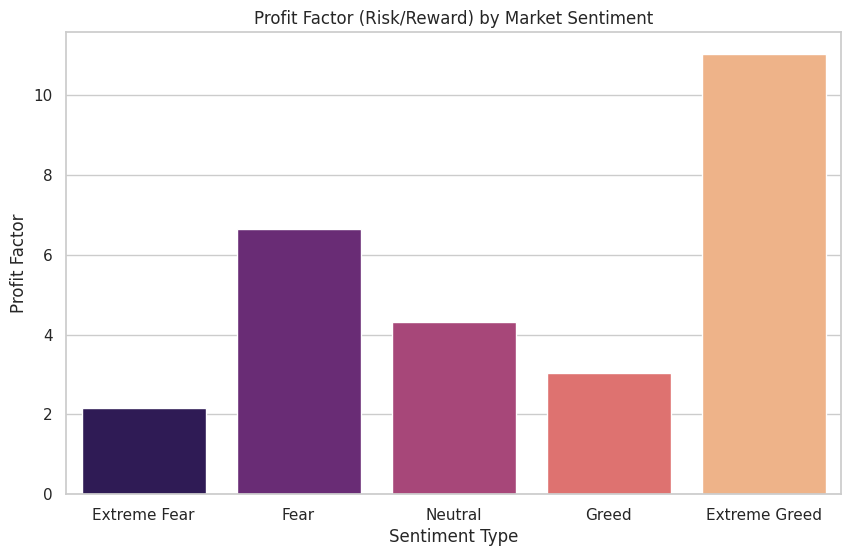

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary,
    x='Sentiment',
    y='Profit_Factor',
    hue='Sentiment',
    palette='magma',
    legend=False
)
plt.title('Profit Factor (Risk/Reward) by Market Sentiment')
plt.xlabel('Sentiment Type')
plt.ylabel('Profit Factor')
plt.savefig('/content/ds_Sunny_Kumar/outputs/profit_factor_by_sentiment.png', bbox_inches='tight')
plt.show()

Plot 2: Win Rate by Sentiment

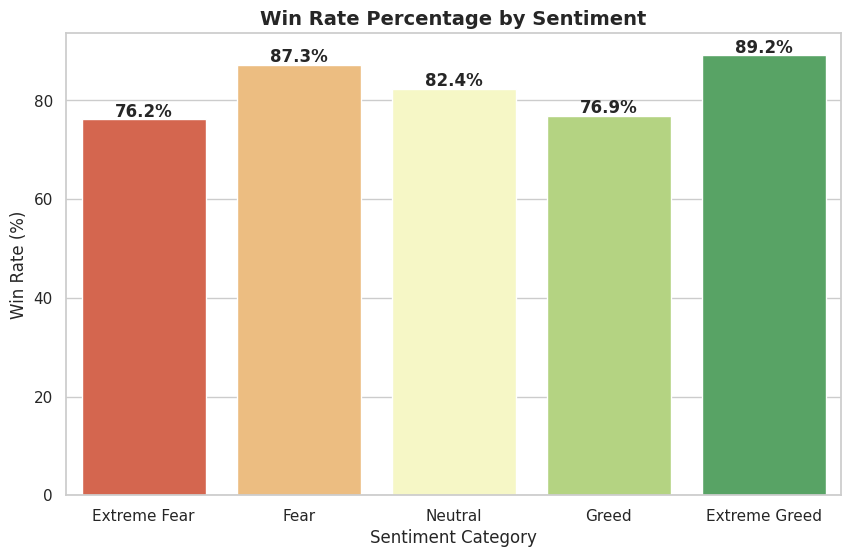

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary,
    x='Sentiment',
    y='Win_Rate_Pct',
    hue='Sentiment',
    palette='RdYlGn',
    legend=False
)

plt.title('Win Rate Percentage by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Win Rate (%)', fontsize=12)

for i, val in enumerate(summary['Win_Rate_Pct']):
    plt.text(i, val + 0.5, f'{val:.1f}%', ha='center', fontweight='bold')

plt.show()
plt.savefig('/content/ds_Sunny_Kumar/outputs/win_rate_by_sentiment.png')

Plot 3: Long vs Short Trade Volume

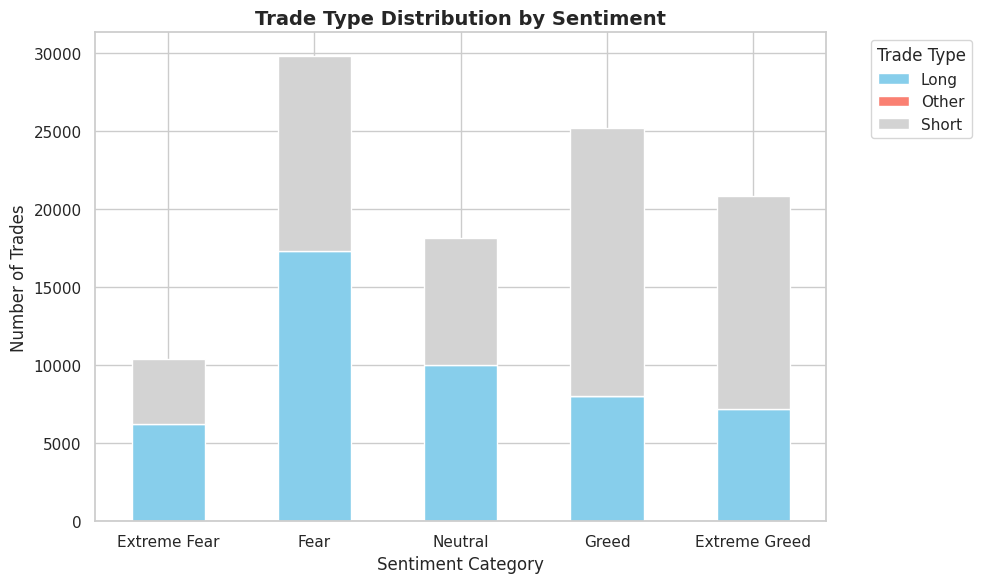

In [ ]:
type_sentiment = pnl_df.groupby(['classification', 'Trade_Type'], observed=False).size().unstack(fill_value=0)
ax = type_sentiment.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['skyblue', 'salmon', 'lightgray'],
    edgecolor='white'
)

plt.title('Trade Type Distribution by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Trades', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Trade Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plot_3_path = f"{base_dir}/outputs/trade_type_distribution.png"
plt.tight_layout()
plt.savefig(plot_3_path, dpi=300)

plt.show()

Plot 4: Cumulative PnL Over Time

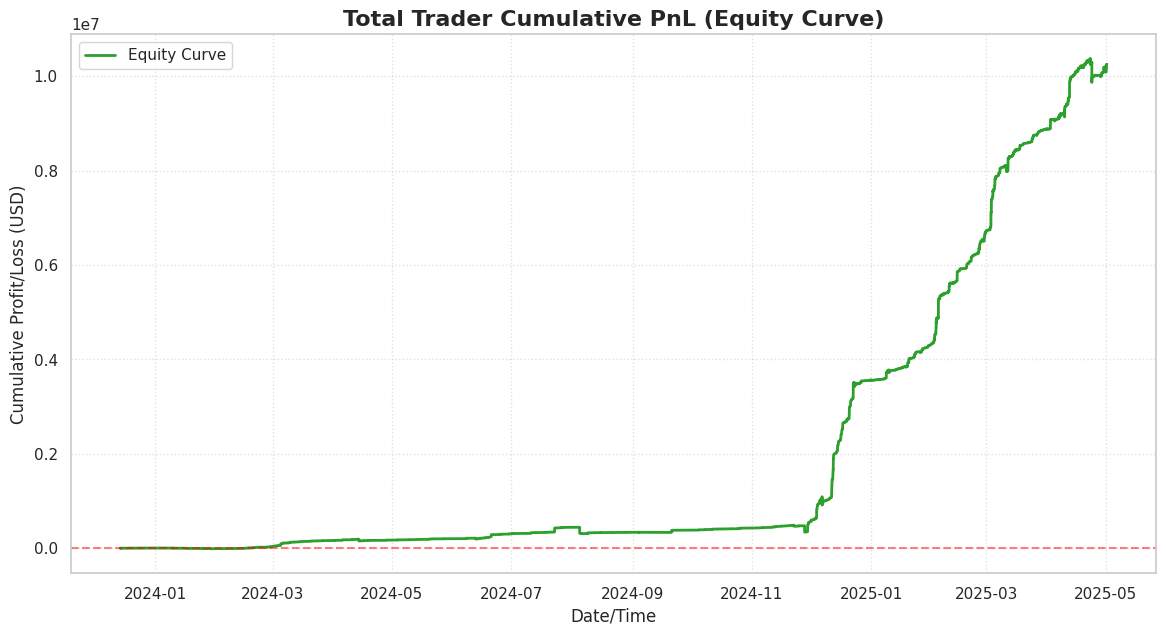

In [ ]:
pnl_df = pnl_df.sort_values('timestamp_dt')
pnl_df['Cumulative_PnL'] = pnl_df['Closed PnL'].cumsum()
plt.figure(figsize=(14, 7))
plt.plot(pnl_df['timestamp_dt'], pnl_df['Cumulative_PnL'], color='#2ca02c', linewidth=2, label='Equity Curve')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)

plt.title('Total Trader Cumulative PnL (Equity Curve)', fontsize=16, fontweight='bold')
plt.xlabel('Date/Time', fontsize=12)
plt.ylabel('Cumulative Profit/Loss (USD)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

plot_4_path = f"{base_dir}/outputs/cumulative_pnl.png"
plt.savefig(plot_4_path, dpi=300, bbox_inches='tight')

plt.show()

Exporting Results

Save processed data for the 'csv_files/' directory

In [ ]:
summary.to_csv('/content/ds_Sunny_Kumar/outputs/sentiment_performance_metrics.csv', index=False)
pnl_df.to_csv('/content/ds_Sunny_Kumar/outputs/processed_trades_master.csv', index=False)

Detailed breakdown for Long/Short analysis

In [ ]:
ls_breakdown = pnl_df.groupby(['classification', 'Trade_Type'], observed=False)['Closed PnL'].mean().unstack()
ls_breakdown.to_csv('/content/ds_Sunny_Kumar/outputs/long_short_pnl_breakdown.csv')

print("\nAll tasks completed. CSVs and Plots generated.")


All tasks completed. CSVs and Plots generated.
